# Import Lib

In [1]:
import sqlite3 as db
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc, style
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import linear_model, neural_network
from sklearn.ensemble import BaggingClassifier
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
font = font_manager.FontProperties(fname="/Library/Fonts/NanumGothic.ttc").get_name()
rc('font', family=font)
style.use('ggplot')

In [3]:
USE_PICKLE    = True
SKIP_RAW_DATA = True

# Data load (Use pickle instead)
db.pkl

In [4]:
if not USE_PICKLE and data is None and not SKIP_RAW_DATA:
    DB_PATH = "./data.db"
    conn = db.connect(DB_PATH)
    data = pd.read_sql("select * from comments order by random()", conn)
    data = data.set_index('index')
    pickle.dump(data, file=open("db.pkl", "wb"))

In [5]:
if USE_PICKLE and not SKIP_RAW_DATA:
    data = pickle.load(open("db.pkl", "rb"))

# Train/Validation/Test Split

In [6]:
if not USE_PICKLE and not SKIP_RAW_DATA:
    data['X_train'], X_test, data['y_train'], y_test = train_test_split(data['comment'].values, data['rating'].values.astype('int64'), test_size=0.40)
    data['X_val'], data['X_test'], data['y_val'], data['y_test'] = train_test_split(X_test, y_test, test_size=0.50)
    print("X_train.shape     : {}\t\t\t y_train.shape: {}".format(data['X_train'].shape, data['y_train'].shape))
    print("X_validation.shape: {}\t\t\t y_validation.shape: {}".format(data['X_val'].shape, data['y_val'].shape))
    print("X_test.shape      : {}\t\t\t y_test.shape: {}".format(data['X_test'].shape, data['y_test'].shape))

In [7]:
if not USE_PICKLE and not SKIP_RAW_DATA:
    data = dict()
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_test']  = X_test
    data['y_test']  = y_test
    data['X_val']   = X_val
    data['y_val']   = y_val
    pickle.dump(data, file=open("train_val_test.pkl", "wb"))

In [8]:
if USE_PICKLE and SKIP_RAW_DATA:
    data = pickle.load(open("train_val_test.pkl", "rb"))

In [118]:
def get_distribution(y_data):
    rating_distribution = np.bincount(y_data)
    rating_distribution = rating_distribution / np.sum(rating_distribution)
    rating_distribution = rating_distribution[1:]
    return rating_distribution

def plot_distribution(rating_distribution):
    plt.bar(np.arange(10)+1, height=rating_distribution, align='center')
    plt.xticks(np.arange(10)+1)
    plt.grid('on')
    plt.title(u"Naver Moving Rating")
    plt.show()
    
def feature_normalize(X):    
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / (std)
    
    return X_norm, mean, std

def normalize_with_train(X, mean, std):
    return (X - mean) / std

def vectorize(X, std):
    test = np.zeros_like(X)    
    test[X >= 0.1 * std] = 1
    test[X < -0.1 * std] = -1
    return test

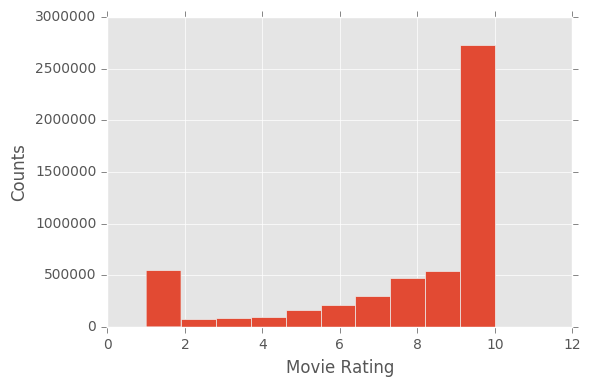

In [143]:
plt.hist(data['y_train'], bins=10, range=(1, 10), align='mid')
plt.xlabel("Movie Rating")
plt.ylabel("Counts")
plt.show()

# Tokenizer and Vectorization

In [144]:
def tokenizer(sentences):
    return sentences.strip().split()

def predict_or_acc(model, vectorizer, X_data, y_data=None):
    test_word_vec = vectorizer.transform(X_data)
    y_pred = model.predict(test_word_vec)
    if y_data is None:
        return y_pred
    else:
        return get_accuracy(y_pred, y_data)

def get_accuracy(y_pred, y_data):
    return np.mean(y_pred == y_data)

def 긍부정_판별기(문장):
    print("INPUT: {}".format(문장))
    result = predict_or_acc(model, vectorizer, [문장])[0]
    if result > 0:
        result = "긍정"
    elif result < 0:
        result = "부정"
    else:
        result = ""
    print("결과: {}".format(result))
    print("")

In [145]:
number_samples = 30000
small_data = {
    "X_train": data['X_train'][:number_samples],
    "y_train": data['y_train'][:number_samples],
    "X_test" : data['X_test'],
    "y_test" : data['y_test'],
    "X_val"  : data['X_val'],
    "y_val"  : data['y_val']    
}

In [146]:
vectorizer = CountVectorizer(tokenizer=tokenizer)
train_word_vectors = vectorizer.fit_transform(small_data['X_train'])
y_train_norm, mean, std = feature_normalize((small_data['y_train'].astype(np.float64)))

In [148]:
model = BaggingClassifier()
model.fit(train_word_vectors, vectorize(y_train_norm, std))

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [149]:
predict_or_acc(model, vectorizer, small_data['X_train'], vectorize(normalize_with_train(small_data['y_train'], mean, std), std))

0.96776666666666666

In [150]:
predict_or_acc(model, vectorizer, small_data['X_val'], vectorize(normalize_with_train(small_data['y_val'], mean, std), std))

0.66773387658452255

In [167]:
stmt = "병신 실망 매우 실망 ㅜㅜ 쓰레기"
긍부정_판별기(stmt)

stmt = "개굳 개쩐다"
긍부정_판별기(stmt)

stmt = "아오 1점도 주기아깝다 알바를 위한 알바에 의한 알바의 영화네  진심재미없네에휴"
긍부정_판별기(stmt)

stmt = "엄두성 재미없다"
긍부정_판별기(stmt)

stmt = "엄두성 잘생겼다"
긍부정_판별기(stmt)

INPUT: 병신 실망 매우 실망 ㅜㅜ 쓰레기
결과: 부정

INPUT: 개굳 개쩐다
결과: 긍정

INPUT: 아오 1점도 주기아깝다 알바를 위한 알바에 의한 알바의 영화네  진심재미없네에휴
결과: 부정

INPUT: 엄두성 재미없다
결과: 부정

INPUT: 엄두성 잘생겼다
결과: 긍정

